In [53]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Hải
[nltk_data]     Nam\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [54]:
# Basic Libs..
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from nltk.stem.porter import *
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
import gensim
from gensim import corpora, models
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from prettytable import PrettyTable
import scipy.sparse
import scipy
import numpy as np
import pandas as pd
import math
import warnings
warnings.filterwarnings("ignore")
print('CWD is ', os.getcwd())

# Vis Libs..

# Text Libs..

# ML Libs...

CWD is  d:\NEU\Năm 3\SEMESTER 6\ĐỀ ÁN DSEB\Mercari Price Prediction\2. Processing


# 3. Data Processing

## 3.1. Train Test Split

In [55]:
'''Load dataset and snapshot'''
df_train = pd.read_csv(
    r'D:\NEU\Năm 3\SEMESTER 6\ĐỀ ÁN DSEB\Mercari Price Prediction\Mercari Dataset\train.tsv', sep ='\t')
df_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [56]:
'''Genrating a 75-25 split between train/test datasets'''
df_train_model, df_test_model = train_test_split(df_train, test_size=0.25)

print('=' * 50)
print('Model training dataset shape : ',df_train_model.shape)
print('=' * 50)
print('Model testing dataset shape : ',df_test_model.shape)
print('=' * 50)

Model training dataset shape :  (1111901, 8)
Model testing dataset shape :  (370634, 8)


In [57]:
'''Storage train and test set'''
file = open('storage/df_train_model', 'wb')
pickle.dump(df_train_model, file)
file.close()

file = open('storage/df_test_model', 'wb')
pickle.dump(df_test_model, file)
file.close()

## 3.2. Data Cleaning


In [58]:
df_train_model = df_train_model[(df_train_model['price'] >= 3) & (df_train_model['price'] <= 2000)]
print(df_train_model.shape)

(1111223, 8)


In [ ]:
file = open('storage/df_train_model', 'wb')
pickle.dump(df_train_model, file)
file.close()

**Summary - Mercari's App platform only allows products listings between 3 and 2000 as per kaggle above, we shall filter data accordingly** 

### 3.2.1. Text Preprocess

**This section performs text processing by cleaning text including removing stopwords, removing special characters, performing, word decontraction, etc**

In [59]:
def decontracted(phrase):
    # specific 
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


# we are removing the words from the stop words list : 'no, 'nor', 'not'
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",
             "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
             'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',
             'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those',
             'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
             'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',
             'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',
             'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',
             'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
             'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very',
             's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're',
             've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',
             "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
             "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't",
             'won', "won't", 'wouldn', "wouldn't"]


def text_preprocess(data):
    preprocessed = []
    # tqdm is for printing the status bar
    for sentence in tqdm_notebook(data):
        sent = decontracted(sentence)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)

        sent = ' '.join(e for e in sent.split() if e not in stopwords)
        preprocessed.append(sent.lower().strip())
    
    return preprocessed

**Replace Missing Text Values with empty strings**

In [60]:
'''Code for replacing Missing Values with empty strings'''
df_train_model['name'] = df_train_model['name'].replace([np.nan], '')
df_test_model['name'] = df_test_model['name'].replace([np.nan], '')

df_train_model['item_description'] = df_train_model['item_description'].replace([np.nan, 'No description yet'], '')
df_test_model['item_description'] = df_test_model['item_description'].replace([np.nan, 'No description yet'], '')

In [61]:
df_train_model['preprocessed_names'] = text_preprocess(df_train_model['name'])
df_test_model['preprocessed_names'] = text_preprocess(df_test_model['name'])

df_train_model['preprocessed_desc'] = text_preprocess(df_train_model['item_description'])
df_test_model['preprocessed_desc'] = text_preprocess(df_test_model['item_description'])

  0%|          | 0/1111223 [00:00<?, ?it/s]

  0%|          | 0/370634 [00:00<?, ?it/s]

  0%|          | 0/1111223 [00:00<?, ?it/s]

  0%|          | 0/370634 [00:00<?, ?it/s]

In [62]:
print(df_train_model['preprocessed_names'].shape)
print(df_train_model['preprocessed_desc'].shape)

(1111223,)
(1111223,)


# 4. Feature Transformation

## 4.1. Feature Transform - Text Data

In [63]:
'''This function takes in Text sentences data and performs BOW/TF - IDF 
vectorization based on parameters input including ngrmas, min_df, max_features etc'''


def text_encoder(train, test, vect_type, params):
    vectorizer = CountVectorizer(ngram_range=params[0],
                                 min_df=params[1],
                                 max_df=params[2],
                                 max_features=params[3]) if vect_type == 'BOW' else TfidfVectorizer(ngram_range=params[0],
                                                                                                    min_df=params[1],
                                                                                                    max_df=params[2],
                                                                                                    max_features=params[3])
    train_transform = vectorizer.fit_transform(train)
    test_transform = vectorizer.transform(test)
    feat_names = vectorizer.get_feature_names_out()
    return train_transform, test_transform, feat_names

In [64]:
# Input params = [ngram, min_df,max_df,max_features]

train_bow_name, test_bow_name, name_feats = text_encoder(df_train_model['preprocessed_names'],
                                                         df_test_model['preprocessed_names'],
                                                         'BOW',
                                                         ((1, 4), 25, 1.0, 50000))

train_bow_desc, test_bow_desc, desc_feats = text_encoder(df_train_model['preprocessed_desc'],
                                                         df_test_model['preprocessed_desc'],
                                                         'BOW',
                                                       ((1, 3),30,1.0,100000))

In [65]:
print(train_bow_name.shape, test_bow_name.shape)
print(train_bow_desc.shape, test_bow_desc.shape)

(1111223, 31796) (370634, 31796)
(1111223, 100000) (370634, 100000)


In [66]:
file = open('storage/train_bow_name', 'wb')
pickle.dump(train_bow_name, file)
file.close()

file = open('storage/test_bow_name', 'wb')
pickle.dump(test_bow_name, file)
file.close()

file = open('storage/train_bow_desc', 'wb')
pickle.dump(train_bow_desc, file)
file.close()

file = open('storage/test_bow_desc', 'wb')
pickle.dump(test_bow_desc, file)
file.close()

## 4.2. Feature Transform - Categorical Features (Brand,Category,Shipping,Item Condition)

In [67]:
'''This Function takes in train, test data and
performs LabelBinarizer encodings on the brand_name column'''

def brand_encoder(train, test):
    vect = LabelBinarizer(sparse_output=True)
    train_transform = vect.fit_transform(train['brand_name'])
    test_transform = vect.transform(test['brand_name'])
    return train_transform, test_transform

df_train_model['brand_name'] = df_train_model['brand_name'].fillna('missing').astype('category')
df_test_model['brand_name'] = df_test_model['brand_name'].fillna('missing').astype('category')
train_brand, test_brand = brand_encoder(df_train_model, df_test_model)
print(train_brand.shape, test_brand.shape)

(1111223, 4440) (370634, 4440)


In [68]:
file = open('storage/train_brand', 'wb')
pickle.dump(train_brand, file)
file.close()

file = open('storage/test_brand', 'wb')
pickle.dump(test_brand, file)
file.close()

In [69]:
''' This function takes in train and test data
and performs One Hot Encodings using countvectorizer 
features on categorical data after using '/' delimiter splitter '''

def category_encoder(train, test):
    unique_categories = pd.Series("/".join(train["category_name"].unique().astype("str")).split("/")).unique()
    count_category = CountVectorizer(vocabulary = unique_categories,lowercase = False,binary = True)
    train_transform = count_category.fit_transform(train["category_name"])
    test_transform = count_category.transform(test['category_name'])
    return train_transform,test_transform

df_train_model['category_name'] = df_train_model['category_name'].fillna('missing').astype('category')
df_test_model['category_name'] = df_test_model['category_name'].fillna('missing').astype('category')

train_category, test_category = category_encoder(df_train_model, df_test_model)
print(train_category.shape, test_category.shape)

(1111223, 942) (370634, 942)


In [70]:
file = open('storage/train_category', 'wb')
pickle.dump(train_category, file)
file.close()

file = open('storage/test_category', 'wb')
pickle.dump(test_category, file)
file.close()

In [71]:
# ds = pd.DataFrame(data = ['Home/Home Décor/Home Décor Accents'], columns = ['category_name'])
# unique_categories = pd.Series("/".join(ds["category_name"].unique().astype("str")).split("/")).unique()
# unique_categories

In [72]:
'''THis function takes in train and test data and performs 
One Hot Encodings on Shipping, Item Condition ID by creating Dummy variable encoding'''

def dummy_encoder(train, test):
    train_transform = scipy.sparse.csr_matrix(pd.get_dummies(train[['item_condition_id',
                                                                     'shipping']], sparse= True).values)
    test_transform = scipy.sparse.csr_matrix(pd.get_dummies(test[['item_condition_id',
                                                                     'shipping']], sparse= True).values)
    return train_transform, test_transform

df_train_model['shipping'] = df_train_model['shipping'].astype('category')
df_test_model['shipping'] = df_test_model['shipping'].astype('category')

df_train_model['item_condition_id'] = df_train_model['item_condition_id'].astype('category')
df_test_model['item_condition_id'] = df_test_model['item_condition_id'].astype('category')

train_dummies, test_dummies = dummy_encoder(df_train_model, df_test_model)
print(train_dummies.shape, test_dummies.shape)

(1111223, 7) (370634, 7)


In [73]:
file = open('storage/train_dummies', 'wb')
pickle.dump(train_dummies, file)
file.close()

file = open('storage/test_dummies', 'wb')
pickle.dump(test_dummies, file)
file.close()

## 4.3. Feature Log Transform - Price 

**Transform price -> log(1 + price)**

In [74]:
# Transforming price -> log(1 + price)
df_train_model['log_price'] = np.log1p(df_train_model['price'])
df_test_model['log_price'] = np.log1p(df_test_model['price'])

**From now on log_price will be our prediction target**

In [ ]:
file = open('storage/y_train', 'wb')
pickle.dump(df_train_model['log_price'], file)
file.close()

file = open('storage/y_test', 'wb')
pickle.dump(df_test_model['log_price'], file)
file.close()

# 5. Feature Engineering

## 5.1. Text Features - 'Item Description' - 7 new features

**This function takes in Item Description Column and generates 7 features
related to sentence length, count of exclamation marks, percentage of uppercase words,
count of special characters like '%*!', hashtags count etc.**

In [75]:
print('Generating features with statistics for item description textual content')

acronyms_regex = re.compile('([A-Z\-0-9]{2,})') # tu viet tat
hashtag_regex = re.compile(r'(#[a-z]{2,})')


def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

# Extracts statistics for each description, words lengths, like percentage of upper-case words, hashtags, etc


def extract_counts(text):
    # Count the numbers of words
    text_size_words_counts = len(text.split(' '))
    # Applies a log transformationusing math.log1p to normalize the distribution
    text_size_words_log_counts = math.log1p(text_size_words_counts)

    # Percentage of Uppercase Words
    full_uppercase_perc = len(acronyms_regex.findall(text)) / float(text_size_words_counts)

    # Log count of punctiation and Markers
    exclamation_log_count = math.log1p(text.count('!'))
    star_log_count = math.log1p(text.count('*'))
    percentage_log_count = math.log1p(text.count('%'))
    price_removed_marker_log_count = math.log1p(text.count('[rm]'))

    # Hash tag count
    hashtag_log_count = math.log1p(len(hashtag_regex.findall(text)))
    return [text_size_words_log_counts,
            full_uppercase_perc,
            exclamation_log_count,
            star_log_count,
            percentage_log_count,
            price_removed_marker_log_count,
            hashtag_log_count]

Generating features with statistics for item description textual content


In [76]:
item_descr_counts = np.vstack(
    df_train_model['item_description'].astype(str).apply(extract_counts).values)
item_descr_counts_scaler = StandardScaler(copy=True)
train_desc_feats = item_descr_counts_scaler.fit_transform(item_descr_counts)
print(train_desc_feats.shape)

(1111223, 7)


In [77]:
item_descr_counts = np.vstack(
    df_test_model['item_description'].astype(str).apply(extract_counts).values)

# Scaling the numeric features columnwise using StandardScaler
item_descr_counts_scaler = StandardScaler(copy=True)
test_desc_feats = item_descr_counts_scaler.fit_transform(item_descr_counts)
print(test_desc_feats.shape)

(370634, 7)


In [78]:
file = open('storage/train_desc_feats', 'wb')
pickle.dump(train_desc_feats, file)
file.close()

file = open('storage/test_desc_feats', 'wb')
pickle.dump(test_desc_feats, file)
file.close()

## 5.2. Text Features - Sentiment Scores (Name, Description) - 2 new features

**This function takes in Text sentence data and returns the compound sentiment score obtained using nlt's sentiment Intensity Analyzer function**

In [79]:
def generate_sentiment_scores(data):
    sid = SentimentIntensityAnalyzer()
    scores = []
    for sentence in tqdm_notebook(data):
        sentence_sentiment_score = sid.polarity_scores(sentence)
        scores.append(sentence_sentiment_score['compound'])
    return scores

In [80]:

train_senti_names = generate_sentiment_scores(df_train_model['preprocessed_names'])
df_train_model['senti_names'] = train_senti_names

test_senti_names = generate_sentiment_scores(df_test_model['preprocessed_names'])
df_test_model['senti_names'] = test_senti_names

  0%|          | 0/1111223 [00:00<?, ?it/s]

  0%|          | 0/370634 [00:00<?, ?it/s]

In [81]:
df_train_model.head(-5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,preprocessed_names,preprocessed_desc,log_price,senti_names
506271,506271,**Google Chromecast**,2,"Electronics/TV, Audio & Surveillance/Gadgets",missing,28.0,1,In like new condition. Only used once. Thanks ...,google chromecast,in like new condition only used thanks looking,3.367296,0.0
1358182,1358182,PINK Navy Blue Sweats,2,Women/Athletic Apparel/Tracksuits & Sweats,PINK,14.0,1,Fitted pant with flare bottom,pink navy blue sweats,fitted pant flare bottom,2.708050,0.0
396341,396341,Selena Gomez & camp rock cds,2,Electronics/Media/CD,missing,10.0,0,,selena gomez camp rock cds,,2.397895,0.0
1249969,1249969,Old Navy V-Neck Logo Short Sleeve Tee,2,Women/Tops & Blouses/T-Shirts,Old Navy,10.0,1,Xxl- NOT woman plus size purple Old Navy T Shi...,old navy v neck logo short sleeve tee,xxl not woman plus size purple old navy t shir...,2.397895,0.0
969083,969083,Patrick Ewing Jersey,3,Men/Athletic Apparel/Jerseys,Nike,19.0,0,Sz XL Rare jersey great shape,patrick ewing jersey,sz xl rare jersey great shape,2.995732,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
496666,496666,Pax 2 - black - brand new!,1,Other/Other/Other,missing,99.0,1,1 (one) brand new pax 2 Black/charcoal color F...,pax 2 black brand new,1 one brand new pax 2 black charcoal color fas...,4.605170,0.0
1120945,1120945,Otterbox iPhone 6/6s case,2,"Electronics/Cell Phones & Accessories/Cases, C...",Apple,16.0,1,New Otterbox iPhone 6/6s case! Bought for [rm]...,otterbox iphone 6 6s case,new otterbox iphone 6 6s case bought rm do not...,2.833213,0.0
960566,960566,NEW Stella & Dot Earrings,2,Women/Jewelry/Earrings,missing,20.0,0,"NEW, never worn Stella & Dot Retired Etoile ea...",new stella dot earrings,new never worn stella dot retired etoile earri...,3.044522,0.0
1366757,1366757,Lularoe guc leggings,4,"Women/Athletic Apparel/Pants, Tights, Leggings",missing,10.0,1,Pilling in crotch and some fading. No holes,lularoe guc leggings,pilling crotch fading no holes,2.397895,0.0


In [82]:
file = open('storage/train_senti_names', 'wb')
pickle.dump(train_senti_names, file)
file.close()

file = open('storage/test_senti_names', 'wb')
pickle.dump(test_senti_names, file)
file.close()

In [83]:
train_senti_desc = generate_sentiment_scores(
    df_train_model['preprocessed_desc'])
df_train_model['senti_desc'] = train_senti_desc

test_senti_desc = generate_sentiment_scores(df_test_model['preprocessed_desc'])
df_test_model['senti_desc'] = test_senti_desc

  0%|          | 0/1111223 [00:00<?, ?it/s]

  0%|          | 0/370634 [00:00<?, ?it/s]

In [84]:
file = open('storage/train_senti_desc', 'wb')
pickle.dump(train_senti_desc, file)
file.close()

file = open('storage/test_senti_desc', 'wb')
pickle.dump(test_senti_desc, file)
file.close()

In [85]:
df_train_model.head(-5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,preprocessed_names,preprocessed_desc,log_price,senti_names,senti_desc
506271,506271,**Google Chromecast**,2,"Electronics/TV, Audio & Surveillance/Gadgets",missing,28.0,1,In like new condition. Only used once. Thanks ...,google chromecast,in like new condition only used thanks looking,3.367296,0.0,0.6597
1358182,1358182,PINK Navy Blue Sweats,2,Women/Athletic Apparel/Tracksuits & Sweats,PINK,14.0,1,Fitted pant with flare bottom,pink navy blue sweats,fitted pant flare bottom,2.708050,0.0,0.0000
396341,396341,Selena Gomez & camp rock cds,2,Electronics/Media/CD,missing,10.0,0,,selena gomez camp rock cds,,2.397895,0.0,0.0000
1249969,1249969,Old Navy V-Neck Logo Short Sleeve Tee,2,Women/Tops & Blouses/T-Shirts,Old Navy,10.0,1,Xxl- NOT woman plus size purple Old Navy T Shi...,old navy v neck logo short sleeve tee,xxl not woman plus size purple old navy t shir...,2.397895,0.0,0.7351
969083,969083,Patrick Ewing Jersey,3,Men/Athletic Apparel/Jerseys,Nike,19.0,0,Sz XL Rare jersey great shape,patrick ewing jersey,sz xl rare jersey great shape,2.995732,0.0,0.6249
...,...,...,...,...,...,...,...,...,...,...,...,...,...
496666,496666,Pax 2 - black - brand new!,1,Other/Other/Other,missing,99.0,1,1 (one) brand new pax 2 Black/charcoal color F...,pax 2 black brand new,1 one brand new pax 2 black charcoal color fas...,4.605170,0.0,0.1710
1120945,1120945,Otterbox iPhone 6/6s case,2,"Electronics/Cell Phones & Accessories/Cases, C...",Apple,16.0,1,New Otterbox iPhone 6/6s case! Bought for [rm]...,otterbox iphone 6 6s case,new otterbox iphone 6 6s case bought rm do not...,2.833213,0.0,-0.0572
960566,960566,NEW Stella & Dot Earrings,2,Women/Jewelry/Earrings,missing,20.0,0,"NEW, never worn Stella & Dot Retired Etoile ea...",new stella dot earrings,new never worn stella dot retired etoile earri...,3.044522,0.0,0.9601
1366757,1366757,Lularoe guc leggings,4,"Women/Athletic Apparel/Pants, Tights, Leggings",missing,10.0,1,Pilling in crotch and some fading. No holes,lularoe guc leggings,pilling crotch fading no holes,2.397895,0.0,-0.2960


# 5.3 Grouped Price Statistics (Category, Brand, Shipping) - 8 new features

**This function groups the [category_name, brand_name, shipping] features and generates aggregate 'price' variable statistics like Mean, Median, Std.Deviation, Price Ranges based on 2 std.deviations from mean coefficient of variance etc. in the Log transformed scale.**

`Outputs are standardized using Standard Scaler funtion`

In [86]:
def generate_cbs_stats(train, test):
    # Group and Aggregation using cat_brand_ship 
    df_group = train.groupby('cat_brand_ship', as_index=False).agg({"shipping": len,
                                                                    "log_price": [np.median, np.mean, np.std, np.min, np.max]})
    
    df_group.columns = ['cat_brand_ship', 'cbs_count', 'cbs_log_price_median', 'cbs_log_price_mean', 'cbs_log_price_std',
                        'cbs_log_price_min', 'cbs_log_price_max']
    
    # Additional Features
    df_group['cbs_log_price_std'] = df_group['cbs_log_price_std'].fillna(0)
    df_group['cbs_log_price_conf_variance'] = df_group['cbs_log_price_std'] / df_group['cbs_log_price_mean']
    df_group['cbs_log_count'] = np.log1p(df_group['cbs_count'])
    df_group['cbs_min_expected_log_price'] = (df_group['cbs_log_price_mean'] - (df_group['cbs_log_price_std']*2)).clip(lower=1.0)
    df_group['cbs_max_expected_log_price'] = (df_group['cbs_log_price_mean'] + (df_group['cbs_log_price_std']*2))
    
    # Merge with Test data
    df_group_stats = test.merge(df_group.reset_index(),
                                how='left',
                                on='cat_brand_ship')[['cbs_log_count',
                                                      'cbs_log_price_mean',
                                                      'cbs_log_price_std',
                                                      'cbs_log_price_conf_variance',
                                                      'cbs_min_expected_log_price',
                                                      'cbs_max_expected_log_price',
                                                      'cbs_log_price_min',
                                                      'cbs_log_price_max']].fillna(0).values

    # Scailing
    scaler = StandardScaler(copy=True)
    cbs_feats_scaled = scaler.fit_transform(df_group_stats)
    return cbs_feats_scaled

In [87]:
df_train_model['cat_brand_ship'] = (df_train_model['category_name'].astype(str) + "_" +
                                    df_train_model['brand_name'].astype(str) + "_" +
                                    df_train_model['shipping'].astype(str))

df_test_model['cat_brand_ship'] = (df_test_model['category_name'].astype(str) + "_" +
                                   df_test_model['brand_name'].astype(str) + "_" +
                                   df_test_model['shipping'].astype(str))
df_train_model['cat_brand_ship']

506271     Electronics/TV, Audio & Surveillance/Gadgets_m...
1358182    Women/Athletic Apparel/Tracksuits & Sweats_PINK_1
396341                        Electronics/Media/CD_missing_0
1249969             Women/Tops & Blouses/T-Shirts_Old Navy_1
969083                   Men/Athletic Apparel/Jerseys_Nike_0
                                 ...                        
409267             Kids/Girls (4+)/Tops & T-Shirts_Justice_0
303431          Women/Pants/Capris, Cropped_American Eagle_0
986923        Women/Athletic Apparel/Sports Bras_Lululemon_1
1014542              Women/Skirts/Straight, Pencil_LuLaRoe_1
306992     Women/Athletic Apparel/Pants, Tights, Leggings...
Name: cat_brand_ship, Length: 1111223, dtype: object

In [88]:
train_cbs_feats = generate_cbs_stats(df_train_model, df_train_model)
test_cbs_feats = generate_cbs_stats(df_train_model, df_test_model)
print(train_cbs_feats.shape, test_cbs_feats.shape)

(1111223, 8) (370634, 8)


In [89]:
file = open('storage/train_cbs_feats', 'wb')
pickle.dump(train_cbs_feats, file)
file.close()

file = open('storage/test_cbs_feats', 'wb')
pickle.dump(test_cbs_feats, file)
file.close()

# 6. Correlation Heatmap of newly generated features

**This code takes the 17 new features generated and checks the co-relation to the output - `$log(1+price)$`
so as to check which features are relevant predictors of the output variable.**

It generates a correlation heatmap


In [90]:
df_corr = pd.concat([pd.DataFrame(train_desc_feats,
                                  columns=['text_size_words_log_counts', 'full_uppercase_perc', 'exclamation_log_count',
                                           'star_log_count', 'percentage_log_count', 'price_removed_marker_log_count',
                                           'hashtag_log_count']),
                    pd.DataFrame(generate_cbs_stats(df_train_model, df_train_model),
                                 columns=['cbs_log_count', 'cbs_log_price_mean', 'cbs_log_price_std',
                                          'cbs_log_price_conf_variance', 'cbs_min_expected_log_price',
                                          'cbs_max_expected_log_price', 'cbs_log_price_min', 'cbs_log_price_max']),
                    df_train_model[['senti_names', 'senti_desc']
                                   ].reset_index(drop=True),
                    df_train_model['log_price'].reset_index(drop = True)], axis = 1)

In [91]:
df_corr.head(4)

,text_size_words_log_counts,full_uppercase_perc,exclamation_log_count,star_log_count,percentage_log_count,price_removed_marker_log_count,hashtag_log_count,cbs_log_count,cbs_log_price_mean,cbs_log_price_std,cbs_log_price_conf_variance,cbs_min_expected_log_price,cbs_max_expected_log_price,cbs_log_price_min,cbs_log_price_max,senti_names,senti_desc,log_price
0,-0.344995,-0.465211,0.842929,-0.202232,-0.215735,-0.287034,-0.060913,0.028003,0.834190,0.811646,0.272603,0.263530,1.035859,-1.169951,0.439638,0.0,0.6597,3.367296
1,-0.922632,-0.465211,-0.514574,-0.202232,-0.215735,-0.287034,-0.060913,0.280974,0.963415,1.942962,1.149308,-0.346528,1.705714,-0.685862,1.520602,0.0,0.0000,2.708050
2,-1.969589,-0.465211,-0.514574,-0.202232,-0.215735,-0.287034,-0.060913,0.211129,-0.689833,-0.126788,0.209839,-0.589419,-0.580831,0.333768,-0.098734,0.0,0.0000,2.397895
3,1.647443,-0.240580,-0.514574,-0.202232,-0.215735,-0.287034,-0.060913,-0.577916,-1.740941,-0.878715,-0.003715,-1.109766,-1.748887,-1.169951,-1.969868,0.0,0.7351,2.397895


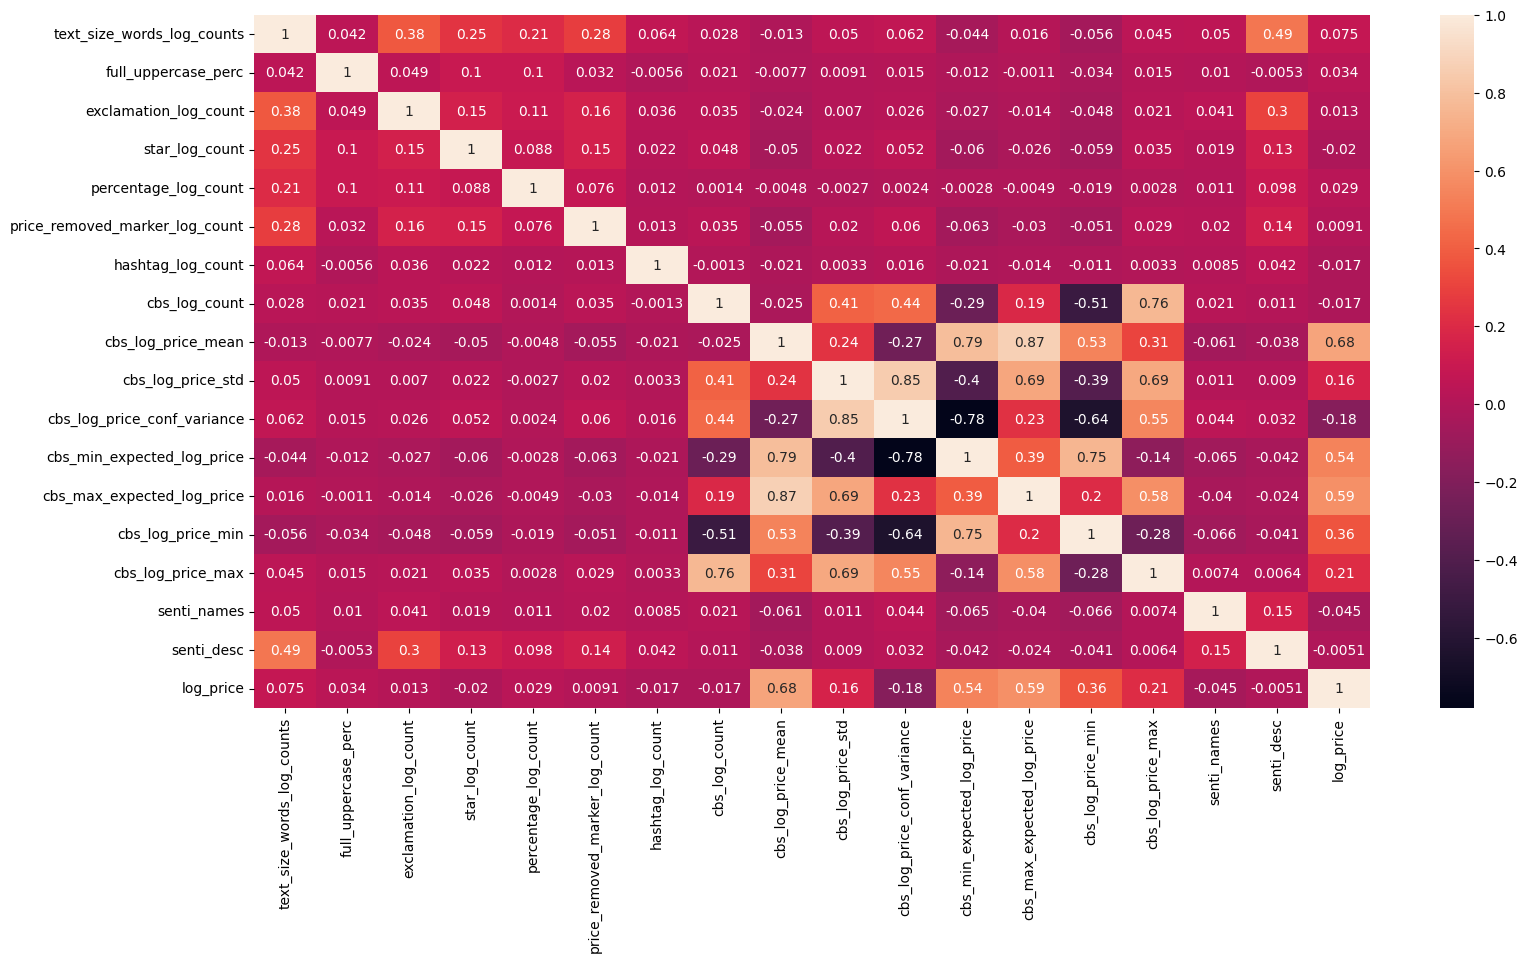

In [92]:
# ref = https://datatofish.com/correlation-matrix-pandas/
corrMatrix = df_corr.corr()

plt.figure(figsize=(18, 9))
sns.heatmap(corrMatrix, annot=True)
plt.show()

**Plot summary - We can see that features - [cbs_log_price_mean, cbs_min_expected_log_price,cbs_max_expected_log_price] are the only 3 features having correlation of >0.5 with log_price output variable. Hence in our ML models, we can choose to keep only these 3 newly generated features out of all the 17 that we generated**